## Step 3: Build spare matrices using FEM approximation

This notebook performs the **data preprocessing and assembly** step for SPDE spatial models:

1. **Coordinate preprocessing** - Projects geographic coordinates and removes duplicates
2. **Mesh generation** - Creates quality triangulation for FEM approximation  
3. **FEM matrix computation** - Builds sparse matrices (C, G, A, Q) for SPDE
4. **Data export** - Saves matrices in CSR format for efficient Stan computation

**Output**: A JSON file (`stan_data.json`) containing all preprocessed data and sparse matrices ready for Stan modeling.

**Note**: The Stan model implementation and SPDE theory are explained in a separate notebook.

#### Libraries

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import warnings

# Add parent directory to path to import geo_spde
sys.path.insert(0, str(Path.cwd().parent))

from geo_spde.coords import preprocess_coords
from geo_spde.mesh import SPDEMesh
from geo_spde.matrices import compute_fem_matrices, compute_spde_matrices_from_mesh
from geo_spde.exceptions import CoordsError, MeshError, MatrixError

#### Load PM2.5 Data

In [2]:
# Load PM2.5 ground monitor data
north_america_log_pm25 = pd.read_csv('north_america_log_pm25.csv')
print(f"Loaded {len(north_america_log_pm25)} ground monitor observations")
north_america_log_pm25.head(3)

Loaded 1339 ground monitor observations


,Year,CityReverseGeocoded,Longitude,Latitude,log_PM25,is_urban,country
0,2018,Whitehorse,-135.0588,60.71972,1.098612,0,1
1,2019,Houston,-126.6468,54.39859,2.397895,0,1
2,2019,Fort Mackay,-111.6424,57.14920,1.945910,0,1


In [3]:
# Extract coordinates and values
log_pm25_coords = north_america_log_pm25[['Longitude','Latitude']].to_numpy()
log_pm25 = north_america_log_pm25['log_PM25'].to_numpy()

print(f"log_PM2.5 range: {log_pm25.min():.1f} - {log_pm25.max():.1f}")
print(f"Mean log PM2.5: {log_pm25.mean():.1f} +/- {log_pm25.std():.1f}")

log_PM2.5 range: -0.1 - 3.6
Mean log PM2.5: 2.0 +/- 0.4


### Step 1: Coordinate Preprocessing

In [4]:
# Preprocess coordinates with automatic projection
clean_coords, indices, proj_info = preprocess_coords(
    log_pm25_coords, 
    remove_duplicates=True  # Remove exact duplicates
)

Detected geographic coordinates (lon/lat)
Auto-detected scale: multi_region (diameter ≈ 10765.0 km)
Projected to: Albers Equal-Area Conic
Characteristic spatial scale: 68728.394 meters
Recommended mesh edge length: 20618.518
Coordinate preprocessing complete: 1339 -> 1339 points
Projected extent: 9102257 × 6147723 meters


In [5]:
print(type(clean_coords))
print(clean_coords.shape)
print(clean_coords[:5, :])
print(type(indices))
print(indices.shape)
print(indices[:5])
print(proj_info)

<class 'numpy.ndarray'>
(1339, 2)
[[-2115244.4294273   2910940.91277434]
 [-1938286.40889789  2060588.97017301]
 [ -969834.44181584  2116349.44079828]
 [ -968883.24096028  2120804.92490464]
 [-1022839.97998489  1785981.89182506]]
<class 'numpy.ndarray'>
(1339,)
[0 1 2 3 4]
{'proj4_string': '+proj=aea +lat_1=25.60 +lat_2=59.81 +lat_0=39.62 +lon_0=-95.25 +datum=WGS84 +units=m +no_defs', 'system': 'Albers Equal-Area Conic', 'scale': 'multi_region', 'projected_bbox': (-6156327.639262478, -2518755.6842113687, 2945929.145523343, 3628967.6448373767), 'hull_diameter_km': 10764.965103219925, 'antimeridian_crossing': False, 'scale_estimates': {'characteristic_scale': 68728.39409931123, 'min_distance': 109.74140522939602, 'median_distance': 1966226.6437757143, 'mesh_recommended_edge': 20618.518229793368}, 'coordinate_units': 'meters', 'unit_to_km': 0.001}


In [6]:
# Preprocess coordinates with automatic projection
clean_coords, indices, proj_info = preprocess_coords(
    log_pm25_coords, 
    remove_duplicates=True  # Remove exact duplicates
)

# Get cleaned observations
north_america_log_pm25_clean = north_america_log_pm25.iloc[indices].copy()
log_pm25_clean = log_pm25[indices]

print(f"\nRetained {len(clean_coords)} unique observation locations")

Detected geographic coordinates (lon/lat)
Auto-detected scale: multi_region (diameter ≈ 10765.0 km)
Projected to: Albers Equal-Area Conic
Characteristic spatial scale: 68728.394 meters
Recommended mesh edge length: 20618.518
Coordinate preprocessing complete: 1339 -> 1339 points
Projected extent: 9102257 × 6147723 meters

Retained 1339 unique observation locations


### Step 2: Mesh Generation

In [7]:
# Create mesh with data-adaptive parameters
mesh = SPDEMesh(clean_coords, proj_info)

# Generate mesh (adjust target_edge_factor for resolution)
vertices, triangles = mesh.create_mesh(
    extension_factor=0.2,
    target_edge_factor=0.3,   # see comparison in Nb2
    min_angle=20.0,          # Minimum triangle angle for stability
    verbose=True
)

Creating mesh for 1339 observation points...
  Target edge length: 589868.0 units
  Cutoff distance: 10.974 units
  Created extended boundary (20% buffer)

Mesh Generation Complete:
  3,579 mesh vertices
  7,096 triangles
  Mesh/observation ratio: 2.7
  Total area: 50365796959911.0 units^2
  Estimated memory for Stan: 0.4 MB


### Step 3: Compute FEM Matrices

We compute four key matrices:
- **C**: Mass matrix (identity operator discretization)
- **G**: Stiffness matrix (Laplacian operator discretization)
- **A**: Projector matrix (mesh to observations)
- **Q**: Precision matrix (for SPDE prior)

In [8]:
# Choose SPDE parameters
# Range parameter: controls spatial correlation distance
# Typical range = 10-20% of domain size
domain_size = np.sqrt(
    (clean_coords[:, 0].max() - clean_coords[:, 0].min()) * 
    (clean_coords[:, 1].max() - clean_coords[:, 1].min())
)
typical_range = domain_size * 0.2
kappa = 1.0 / typical_range  # For Matérn nu=1/2

print(f"Domain size: {domain_size/1000:.0f} km")
print(f"Correlation range: {typical_range/1000:.0f} km")
print(f"Kappa parameter: {kappa:.2e}")

Domain size: 7481 km
Correlation range: 1496 km
Kappa parameter: 6.68e-07


In [9]:
# Compute matrices for Matérn nu=1/2 (alpha=1)
C, G, A, Q = compute_spde_matrices_from_mesh(
    mesh,
    kappa=kappa,
    alpha=1,  # Matérn nu=1/2 (exponential covariance)
    verbose=True
)

Computing FEM matrices (vectorized):
  Mesh: 3579 vertices, 7096 triangles
  Observations: 1339 points
  Computing C matrix (Mass)...
  Computing G matrix (Stiffness)...
  Computing A matrix (Projector)...
  Computing Q matrix (Matern nu=1/2 precision)...
  FEM matrix computation complete

Matrix Diagnostics:
  C matrix: 3579x3579, 24,927 non-zeros (0.19% dense)
  G matrix: 3579x3579, 24,927 non-zeros (0.19% dense)
  A matrix: 1339x3579, 4,013 non-zeros (0.084% dense)
    Average entries per observation: 3.0
  Q matrix: 3579x3579, 24,927 non-zeros (0.19% dense)
  Estimated memory: 0.6 MB


In [ ]:
# Compute matrices for Matérn nu=3/2 (alpha=2)
# C, G, A, Q = compute_spde_matrices_from_mesh(
#    mesh,
#    kappa=kappa,
#    alpha=2,  # Matérn nu=3/2 (smooth covariance)
#    verbose=True
#)

### Visualize Matrix Sparsity Patterns

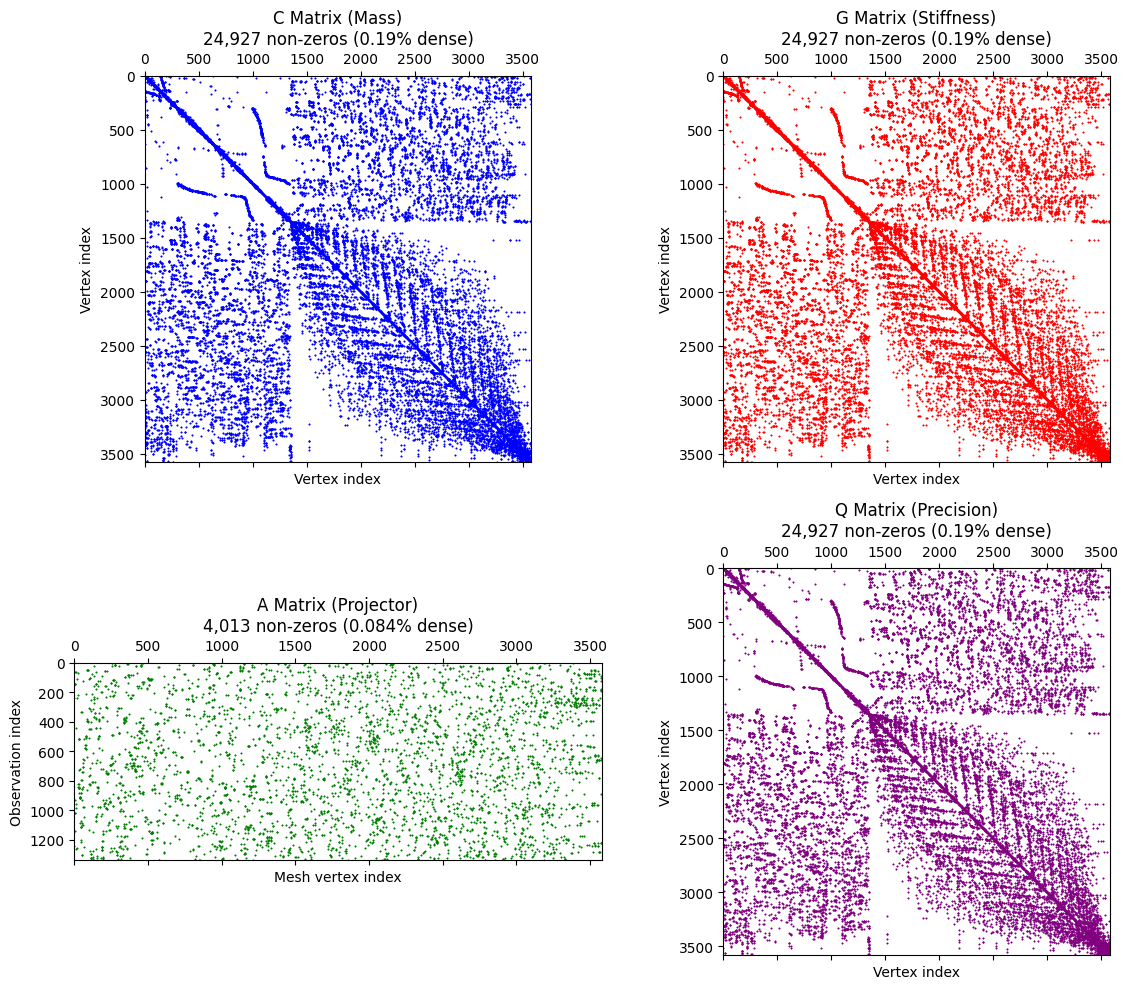

In [12]:
# Create sparsity pattern plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# C matrix (Mass matrix)
axes[0, 0].spy(C, markersize=0.5, color='blue')
axes[0, 0].set_title(f'C Matrix (Mass)\n{C.nnz:,} non-zeros ({C.nnz/(C.shape[0]*C.shape[1])*100:.2f}% dense)')
axes[0, 0].set_xlabel('Vertex index')
axes[0, 0].set_ylabel('Vertex index')

# G matrix (Stiffness matrix)
axes[0, 1].spy(G, markersize=0.5, color='red')
axes[0, 1].set_title(f'G Matrix (Stiffness)\n{G.nnz:,} non-zeros ({G.nnz/(G.shape[0]*G.shape[1])*100:.2f}% dense)')
axes[0, 1].set_xlabel('Vertex index')
axes[0, 1].set_ylabel('Vertex index')

# A matrix (Projector matrix)
axes[1, 0].spy(A, markersize=0.5, color='green')
axes[1, 0].set_title(f'A Matrix (Projector)\n{A.nnz:,} non-zeros ({A.nnz/(A.shape[0]*A.shape[1])*100:.3f}% dense)')
axes[1, 0].set_xlabel('Mesh vertex index')
axes[1, 0].set_ylabel('Observation index')

# Q matrix (Precision matrix)
axes[1, 1].spy(Q, markersize=0.5, color='purple')
axes[1, 1].set_title(f'Q Matrix (Precision)\n{Q.nnz:,} non-zeros ({Q.nnz/(Q.shape[0]*Q.shape[1])*100:.2f}% dense)')
axes[1, 1].set_xlabel('Vertex index')
axes[1, 1].set_ylabel('Vertex index')

plt.tight_layout()
plt.savefig('matrices.png', bbox_inches='tight')
plt.show()

### Matrix Properties Analysis

In [11]:
# Analyze matrix properties
print("Matrix Properties:")
print("="*50)

# C matrix analysis
C_diag = C.diagonal()
print(f"\nC Matrix (Mass):")
print(f"  Shape: {C.shape}")
print(f"  Diagonal range: [{C_diag.min():.6f}, {C_diag.max():.6f}]")
print(f"  Symmetric: {np.allclose(C.toarray(), C.toarray().T)}")
print(f"  Positive definite: {np.all(C_diag > 0)}")

# G matrix analysis
G_diag = G.diagonal()
print(f"\nG Matrix (Stiffness):")
print(f"  Shape: {G.shape}")
print(f"  Diagonal range: [{G_diag.min():.6f}, {G_diag.max():.6f}]")
print(f"  Symmetric: {np.allclose(G.toarray(), G.toarray().T)}")
print(f"  Positive semi-definite: {np.all(G_diag >= 0)}")

# A matrix analysis
row_sums = np.array(A.sum(axis=1)).flatten()
print(f"\nA Matrix (Projector):")
print(f"  Shape: {A.shape} (n_obs x n_mesh)")
print(f"  Row sums range: [{row_sums.min():.6f}, {row_sums.max():.6f}]")
print(f"  Rows sum to 1: {np.allclose(row_sums, 1.0)}")
print(f"  Avg entries per observation: {A.nnz / A.shape[0]:.1f}")

# Q matrix analysis
Q_diag = Q.diagonal()
print(f"\nQ Matrix (Precision):")
print(f"  Shape: {Q.shape}")
print(f"  Diagonal range: [{Q_diag.min():.6f}, {Q_diag.max():.6f}]")
print(f"  Symmetric: {np.allclose(Q.toarray(), Q.toarray().T)}")
print(f"  Condition number estimate: {Q_diag.max() / Q_diag.min():.2e}")

Matrix Properties:

C Matrix (Mass):
  Shape: (3579, 3579)
  Diagonal range: [69594.680125, 169889470269.118073]
  Symmetric: True
  Positive definite: True

G Matrix (Stiffness):
  Shape: (3579, 3579)
  Diagonal range: [1.416124, 6.428575]
  Symmetric: True
  Positive semi-definite: True

A Matrix (Projector):
  Shape: (1339, 3579) (n_obs x n_mesh)
  Row sums range: [1.000000, 1.000000]
  Rows sum to 1: True
  Avg entries per observation: 3.0

Q Matrix (Precision):
  Shape: (3579, 3579)
  Diagonal range: [1.429510, 6.428588]
  Symmetric: True
  Condition number estimate: 4.50e+00


### Export Matrices for Stan in CSR Format

Stan's `csr_matrix_times_vector()` function requires CSR (Compressed Sparse Row) format for optimal performance. This is 10-100x faster than custom sparse matrix functions.

In [ ]:
def export_csr_for_stan(matrix, name, return_dict=True):
    """
    Export sparse matrix in CSR format for Stan's csr_matrix_times_vector().
    
    Stan CSR format requires:
    - w: values (non-zero entries)
    - v: column indices (1-indexed)
    - u: row start positions (1-indexed, length = n_rows + 1)
    """
    # Convert to CSR format
    mat_csr = matrix.tocsr()
    
    # Create dictionary with 1-indexed arrays (Stan uses 1-indexing)
    stan_data = {
        f'{name}_w': mat_csr.data,
        f'{name}_v': (mat_csr.indices + 1).astype(int),  # column indices, 1-indexed
        f'{name}_u': (mat_csr.indptr + 1).astype(int),   # row pointers, 1-indexed
        f'{name}_nnz': int(mat_csr.nnz),
        f'{name}_nrow': int(mat_csr.shape[0]),
        f'{name}_ncol': int(mat_csr.shape[1])
    }
    
    print(f"Exported {name} matrix in CSR format:")
    print(f"  Shape: {mat_csr.shape}")
    print(f"  Non-zeros: {mat_csr.nnz:,}")
    print(f"  Data arrays: {name}_w[{len(stan_data[f'{name}_w'])}], "
          f"{name}_v[{len(stan_data[f'{name}_v'])}], "
          f"{name}_u[{len(stan_data[f'{name}_u'])}]")
    
    if return_dict:
        return stan_data
    else:
        return mat_csr

In [ ]:
# Export matrices for Stan
print("Exporting matrices for Stan in CSR format...\n")

# We only need A and Q for the basic SPDE model
# C and G are used to construct Q, but not needed in Stan directly
A_stan = export_csr_for_stan(A, "A")
Q_stan = export_csr_for_stan(Q, "Q")

# Combine all Stan data
stan_data = {
    'N_obs': int(len(clean_coords)),
    'N_vertices': int(len(vertices)),
    'N_countries': 3,
    'y': log_pm25_clean,
    'is_urban': is_urban_clean.astype(int),
    'country': country_clean.astype(int),
    'prior_mean': float(log_pm25_clean.mean()),
    **A_stan,
    **Q_stan
}

print(f"\nComplete Stan data dictionary prepared with {len(stan_data)} fields")
print(f"Key dimensions: N_obs={stan_data['N_obs']}, N_vertices={stan_data['N_vertices']}")

### Export Data for Stan

All preprocessed data and sparse matrices are saved in a single JSON file for use with the Stan model.

In [ ]:
# Save using CmdStanPy's write_stan_json for proper formatting
from cmdstanpy import write_stan_json

output_dir = Path("json_data")
output_dir.mkdir(exist_ok=True)

# Save to JSON using CmdStanPy's function
stan_json_path = output_dir / "stan_data.json"
write_stan_json(stan_json_path, stan_data)

print(f"Stan data saved to {stan_json_path}")
print(f"\nThis file contains:")
print(f"  - {stan_data['N_obs']} observations")
print(f"  - {stan_data['N_vertices']} mesh vertices")
print(f"  - Sparse matrix A: {A.shape} with {A.nnz:,} non-zeros")
print(f"  - Sparse matrix Q: {Q.shape} with {Q.nnz:,} non-zeros")
print(f"\nReady for use with gp_pm25.stan model")

### Summary

We've successfully:

1. **Preprocessed coordinates** - Projected from lon/lat to appropriate map projection
2. **Generated quality mesh** - Created triangulation with controlled quality
3. **Computed FEM matrices** - Built C, G, A, Q matrices for SPDE approximation
4. **Exported in CSR format** - Optimized sparse format for Stan's native functions

The saved JSON file `json_data/stan_data.json` provides all inputs needed by the SPDE models.